In [102]:
from sklearn.utils import murmurhash3_32
import random
import sys

random.seed(13)

def h(x, seed, R):
    return murmurhash3_32(key=x, seed=seed) % R

class CountMinSketch:
  def __init__(self, d: int, R: int):
    self.d = d
    self.R = R
    self.array = []

    for _i in range(d):
      self.array.append([0] * R)

  def insert(self, token: str):
    for i in range(self.d):
      hash = h(token, i, self.R)
      self.array[i][hash] += 1

  def query(self, token: str):
    res = []
    for i in range(self.d):
      hash = h(token, i, self.R)
      res.append(self.array[i][hash])
    return min(res)
  
  def get_memory_usage(self):
    memory = sys.getsizeof(self)
    for subarray in self.array:
      memory += sys.getsizeof(subarray)
    return memory

In [103]:
from collections import defaultdict

class CountMinSketchWithOracle(CountMinSketch):
  def __init__(self, d: int, R: int, oracle: callable):
    super().__init__(d, R)
    self.oracle = oracle
    self.heavy_hitter_counts = defaultdict(int)
  def insert(self, token: str):
    if token in self.heavy_hitter_counts or self.oracle(token) == 1:
      self.heavy_hitter_counts[token] += 1
      # print(self.heavy_hitter_counts)
    else:
      super().insert(token)
  def query(self, token: str):
    if token in self.heavy_hitter_counts:
      # print(self.heavy_hitter_counts)
      return self.heavy_hitter_counts[token]
    else:
      return super().query(token)
  def get_memory_usage(self):
    return super().get_memory_usage() + sys.getsizeof(self.oracle) + sys.getsizeof(self.heavy_hitter_counts)

In [104]:
# sketch = CountMinSketch(10, 2 ** 20)
# sketch.insert("Taha")
# sketch.insert("Hi")
# sketch.insert("Taha")
# print(sketch.query("Taha"))
# print(sketch.query("Hi"))
# print(sketch.query("Teet"))

In [105]:
# oracle_sketch = CountMinSketchWithOracle(5, 2 ** 16, lambda x: 1 if x == "Taha" else 0)
# oracle_sketch.insert("Taha")
# oracle_sketch.insert("hi")
# oracle_sketch.insert("Taha")
# print(oracle_sketch.query("Taha"))
# print(oracle_sketch.query("hi"))
# print(oracle_sketch.query("hsi"))

In [106]:
import pandas as pd

queries = []
for i in range(1, 2):
    data = pd.read_csv('data/aol/user-ct-test-collection-0' + str(i) + '.txt', sep="\t")
    queries.extend(data.Query.dropna())

In [107]:
from collections import Counter 

tokens_freq = Counter(queries)

In [108]:
print(len(tokens_freq))

1216652


In [377]:
print(tokens_freq.most_common(600))

[('-', 98991), ('google', 32163), ('yahoo', 13646), ('ebay', 13075), ('yahoo.com', 8743), ('mapquest', 8719), ('myspace.com', 8587), ('google.com', 7985), ('myspace', 6877), ('www.yahoo.com', 4240), ('internet', 4207), ('www.google.com', 3981), ('www.myspace.com', 3034), ('my space', 3008), ('ebay.com', 2978), ('map quest', 2899), ('http', 2840), ('weather', 2676), ('pogo', 2307), ('american idol', 2279), ('craigslist', 2232), ('dictionary', 2205), ('msn.com', 2140), ('hotmail', 2093), ('bank of america', 2069), ('msn', 2045), ('hotmail.com', 1939), ('yahoo mail', 1890), ('ask jeeves', 1810), ('bankofamerica', 1743), ('pokemon', 1720), ('mycl.cravelyrics.com', 1675), ('my space.com', 1629), ('ask.com', 1591), ('walmart', 1517), ('mapquest.com', 1486), ('tattoo', 1397), ('horoscopes', 1272), ('southwest airlines', 1259), ('.com', 1258), ('maps', 1214), ('myspace layouts', 1188), ('www.google', 1131), ('target', 1076), ('white pages', 1075), ('home depot', 1068), ('sex', 1058), ('porn', 

In [110]:
freq_tokens = tokens_freq.most_common(100)
infreq_tokens = tokens_freq.most_common()[:-101:-1]
random_tokens = random.sample(tokens_freq.items(), 100)

/var/folders/4n/ghvzsdpj5nq5mtt0z1brxsm00000gn/T/ipykernel_91948/737723934.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_tokens = random.sample(tokens_freq.items(), 100)


In [196]:
common_tokens = tokens_freq.most_common(1000)

In [412]:
D = 4

In [413]:
# sketch = CountMinSketch(D, R)

In [438]:
sketches = [CountMinSketch(D, 2 ** R) for R in range(13, 17)]

In [439]:
for query in queries:
    for sketch in sketches:
        sketch.insert(query)

In [440]:
def perfect_oracle(token):
    if token in tokens_freq and tokens_freq[token] >= 200:
        return 1
    else: 
        return 0
# sketch_with_oracle = CountMinSketchWithOracle(D, R, perfect_oracle)
sketches_with_oracles = [CountMinSketchWithOracle(D, 2 ** R, perfect_oracle) for R in range(13, 17)]

In [441]:
# for query in queries:
#     sketch_with_oracle.insert(query)
for query in queries:
    for sketch in sketches_with_oracles:
        sketch.insert(query)

In [442]:
from statistics import mean, median

def get_error_statistics(sketch, token_counts):
    errors = []
    for token, actual_count in token_counts:
        estimated_count = sketch.query(token)
        errors.append(abs(estimated_count - actual_count))
    return mean(errors), median(errors)

In [443]:
# print("Min Sketch")
# errors = get_error_statistics(sketch, tokens_freq.items())
# print("Mean error:", errors[0])
# print("Median error:", errors[1])
# print("Memory usage:", str(sketch.get_memory_usage() / (10 ** 6)), "MB")
# print()

# print("Min Sketch With Perfect Oracle")
# errors = get_error_statistics(sketch_with_oracle, tokens_freq.items())
# print("Mean error:", errors[0])
# print("Median error:", errors[1])
# print("Memory usage:", str(sketch_with_oracle.get_memory_usage() / (10 ** 6)), "MB")

In [444]:
# import matplotlib.pyplot as plt

# def plot_errors(sketch, sketch_with_oracle, token_counts, title=""):

#   min_sketch_errors = []
#   sketch_with_oracle_errors = []

#   for token, actual_count in token_counts:
#     estimated_count = sketch.query(token)
#     min_sketch_errors.append(abs(estimated_count - actual_count)/actual_count)

#     estimated_count = sketch_with_oracle.query(token)
#     sketch_with_oracle_errors.append(abs(estimated_count - actual_count)/actual_count)

#   plt.plot(min_sketch_errors, label = "Count Min Sketch")
#   plt.plot(sketch_with_oracle_errors, label = "Count Min Sketch With Oracle")
#   plt.xlabel("Token")
#   plt.ylabel("Error")
#   plt.title(title)
#   plt.legend()
#   plt.show()

In [445]:
# plot_errors(sketch, sketch_with_oracle, freq_tokens, "Error For Most Frequent Words")
# plot_errors(sketch, sketch_with_oracle, infreq_tokens, "Error For Most Infrequent Words")
# plot_errors(sketch, sketch_with_oracle, random_tokens, "Error For Random Words")

In [446]:
def calculate_error_vs_memory(sketches, sketches_with_oracle, token_counts, title=""):

  min_sketch_errors = []
  min_sketch_memory = []
  sketch_with_oracle_errors = []
  sketch_with_oracle_memory = []

  for sketch in sketches:
    min_sketch_errors.append(get_error_statistics(sketch, token_counts)[0])
    min_sketch_memory.append(sketch.get_memory_usage())

  for sketch in sketches_with_oracle:
    sketch_with_oracle_errors.append(get_error_statistics(sketch, token_counts)[0])
    sketch_with_oracle_memory.append(sketch.get_memory_usage())

  return min_sketch_errors, min_sketch_memory, sketch_with_oracle_errors, sketch_with_oracle_memory

In [447]:
min_sketch_errors, min_sketch_memory, sketch_with_oracle_errors, sketch_with_oracle_memory = calculate_error_vs_memory(sketches, sketches_with_oracles, common_tokens)

In [448]:
print(min_sketch_errors)
print(min_sketch_memory)
print(sketch_with_oracle_errors)
print(sketch_with_oracle_memory)

[310.075, 144.442, 65.006, 27.67]
[262416, 524560, 1048848, 2097424]
[146.828, 68.592, 31.038, 13.212]
[281080, 543224, 1067512, 2116088]


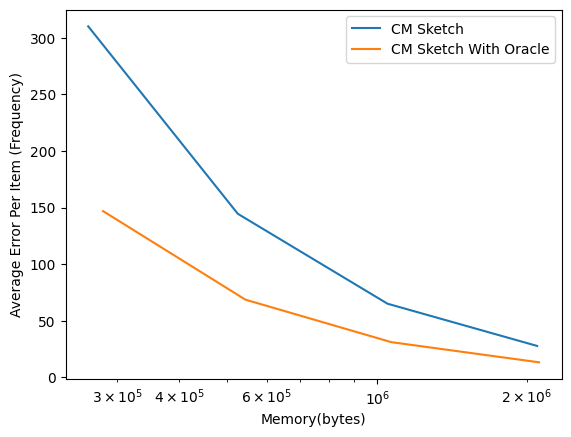

In [451]:
plt.xscale("log")
plt.plot(min_sketch_memory, min_sketch_errors, label = "CM Sketch")
plt.plot(sketch_with_oracle_memory, sketch_with_oracle_errors, label = "CM Sketch With Oracle")
plt.xlabel("Memory(bytes)")
plt.ylabel("Average Error Per Item (Frequency)")
plt.legend()
plt.show()